# DEEPSMOTE + EFFICIENTNET

## I. Introduction

### a. Library Python

In [ ]:
args = {}
# path of file


### e. Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()#args=>channel=3

        self.channel_img = args['channel_img'] # 3 rgb
        self.hidden_size = args['hidden_size'] #64 neuron
        self.flatten_size = args['flatten_size'] #100 feature extraction

        self.conv = nn.Sequential(
            nn.Conv2d(self.channel_img, self.hidden_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size, self.hidden_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 2, self.hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 4, self.hidden_size * 8, 4, 2, 1, bias=False),

            nn.BatchNorm2d(self.hidden_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(self.hidden_size * (2**3) *14*14, self.flatten_size)

    def forward(self, x):
        x = self.fc(self.conv(x).reshape(x.size(0), -1))
        return x

### f. Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        #setting arguments
        self.channel_img = args['channel_img']
        self.hidden_size = args['hidden_size']
        self.flatten_size = args['flatten_size']

        #layers decoder
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, self.hidden_size * 8 * 14 * 14),
            nn.ReLU(0.2)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_size * 8, self.hidden_size * 4, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 4, self.hidden_size *2, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 2, self.hidden_size, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size, self.channel_img, 4,2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.deconv(self.fc(x).reshape(x.size(0), self.hidden_size * 8, 14, 14))
        return x

### g. DeepSMOTE

In [ ]:
class DeepSMOTE:
  def __init__(self, encoder, decoder):
    self.encoder,self.decoder,self.criterion, self.epochs = encoder, decoder, nn.MSELoss(), args['epochs']

  def compile(self, optim, lr):
    if optim =='adam':
      self.enc_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
      self.dec_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=lr)

  def preprocess(self, X):
    self.minibatch = X
    self.data_x, self.data_y = self.minibatch['images'].permute(0,3,1,2)/255.0, self.minibatch['class']

    self.classes = torch.unique(self.minibatch['class']).numpy()

    self.dataTensor = TensorDataset(self.data_x, self.data_y)
    self.train_loader = DataLoader(self.dataTensor, batch_size = 100, shuffle=True, num_workers = 0)

  def save_encode_decode(self, level):
    torch.save(self.encoder.state_dict(), args['oversample']+level+"_encode.pth")
    torch.save(self.decoder.state_dict(), args['oversample']+level+"_decode.pth")

  def SMOTE(self, X, n_generate, Class):
    #knn training for nearest neighbor
    kNN = NearestNeighbors(n_neighbors=5, n_jobs=1)
    kNN.fit(X)
    dist, ind = kNN.kneighbors(X)

    #generatting random index
    base = np.random.choice(list(range(len(X))), n_generate)
    NNindex = np.random.choice(list(range(5)), n_generate)

    #locating index at X
    X_base = X[base]
    X_nn = X[ind[base, NNindex]]

    #generate
    generate_sample = X_base + torch.mul(torch.from_numpy(np.random.rand(n_generate,1)),
                                         X_nn - X_base)

    return generate_sample, torch.tensor([Class]*n_generate)

  def fit(self, X, device):
    self.encoder = self.encoder.to(device)
    self.decoder = self.decoder.to(device)
    self.criterion = self.criterion.to(device)
    self.perform = {'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

    self.preprocess(X)
    self.compile('adam', args['lr'])
    time_start = time.time()
    best_loss = 99

    #training with epoch
    for epoch in range(self.epochs):
      train_loss, rec_loss, penalty_loss = 0, 0, 0
      self.encoder.train()
      self.decoder.train()

      # batching on train_loader
      for images, labels in self.train_loader:
        self.encoder.zero_grad()
        self.decoder.zero_grad()

        images = images.to(device)
        labels_np = labels.detach().cpu().numpy()

        #encode-decode every batch
        mse = self.criterion(self.decoder(self.encoder(images)), images)

        #select class dan pengacakan class (CD)
        class_cd = np.random.choice(self.classes)
        x_cd,y_cd = images[labels == class_cd], labels[labels == class_cd]

        size_x = len(x_cd)
        i_shuffle = np.random.choice(list(range(size_x)), size_x, replace = False )
        xclass_cd, yclass_cd = images[i_shuffle], labels[i_shuffle]

        #Pengacakan anggota class CD menjadi cb
        size_cd = len(xclass_cd)
        j_shuffle = np.random.choice(list(range(size_cd)), size_cd, replace = False)
        xclass_cb = xclass_cd[j_shuffle]

        #encode xclass cd
        xclass_cd = xclass_cd.to(device)
        xclass_es = self.encoder(xclass_cd).detach()

        #permute encode cd #menggunakan pengacakan cb, indeksnya akan dicocokan dengan CD sebelum diekstrak
        xclass_pe = xclass_es[j_shuffle]

        #decode dp
        xclass_pe = xclass_pe.to(device)
        xclass_dp = self.decoder(xclass_pe)

        #penalty loss
        mse2 = self.criterion(xclass_dp, xclass_cb)

        combo_loss = mse + mse2
        combo_loss.backward()

        self.enc_optimizer.step()
        self.dec_optimizer.step()

        train_loss += combo_loss.item()
        rec_loss += mse.item()
        penalty_loss += mse2.item()

      #hitung training loss setiap epoch berdasarkan jumlah train loader
      train_loss = train_loss / len(self.train_loader)
      rec_loss = rec_loss / len(self.train_loader)
      penalty_loss = penalty_loss / len(self.train_loader)
      # 'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

      self.perform['train_loss'].append(train_loss)
      self.perform['rec_loss'].append(rec_loss)
      self.perform['penalty_loss'].append(penalty_loss)
      print(f"Epoch :{epoch+1} Train Loss: {train_loss} Rec Loss: {rec_loss} Penalty_loss: {penalty_loss}")

      if train_loss < best_loss:
        print("Menyimpan Model ....")
        self.save_encode_decode("best")
        best_loss = train_loss

    time_stop = time.time()
    self.timer = (time_stop - time_start)/60

    save_cachedImg(args['oversample']+"_perform.pkl",self.perform)

  def generate_samples(self, limit, target, device):

    self.path_encoder = args['oversample']+"best_encode.pth"
    self.path_decoder = args['oversample']+"best_decode.pth"
    self.gen_timer = time.time()
    self.encoder.load_state_dict(torch.load(self.path_encoder, map_location=device), strict=False)
    self.decoder.load_state_dict(torch.load(self.path_decoder, map_location=device), strict=False)

    self.encoder.to(device)
    self.decoder.to(device)

    self.encoder.eval()
    self.decoder.eval()

    gen_x = []
    gen_y = []
    for cls in self.classes:

      # process data
      x_class, y_class = self.data_x[self.data_y == cls], self.data_y[self.data_y == cls]
      x_class_l, y_class_l = x_class[:limit], y_class[:limit]
      x_class_l = x_class_l.to(device)

      #encodering
      x_class_l = self.encoder(x_class_l).detach().cpu()

      #SMOTE
      n_generate = target - len(y_class)
      x_sample, y_sample = self.SMOTE(x_class_l, n_generate, cls) #output torch dtype
      x_sample = x_sample.float().to(device)

      #decodering
      x_decode = self.decoder(x_sample).detach().cpu()
      x_decode = x_decode.permute(0,2,3,1)*255.0

      #saving
      gen_x.append(x_decode.to(dtype=torch.float16))
      gen_y.append(y_sample)

    # combine result torch all of class in one tensor

    combine_gen = {'images': torch.cat(gen_x, dim=0), 'class': torch.cat(gen_y, dim=0)}
    save_cachedImg(args['hasil_oversampling']+"combine_oversampling.pkl", combine_gen)

    #combine result torch with data
    self.combine_data = {'images':torch.cat([(self.data_x.permute(0,2,3,1)*255.0).to(dtype=torch.float16),
                                             torch.cat(gen_x, dim=0)], dim=0),
                         'class':torch.cat([self.data_y,
                                            torch.cat(gen_y, dim=0)], dim=0)}
    save_cachedImg(args['hasil_oversampling']+"combine_oversampling_with_data.pkl", self.combine_data)

    self.gen_timer = time.time()-self.gen_timer
    print(self.gen_timer/60)

### h.Class EfficientNet

In [ ]:
class EfficientNetClassification(nn.Module):
    def __init__(self, version):
        super(EfficientNetClassification, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-'+version)
        in_features = self.efficientnet._fc.in_features
        num_class = len(args['class'])
        self.efficientnet._fc = nn.Linear(in_features, num_class)
        self.version = version

    def forward(self, x):
        return self.efficientnet(x)



### i. Classification with K-Fold

In [ ]:
#preprocessing, training+validation, testing,
class Classification:
  def __init__(self, model, epochs):
    self.model, self.criterion, self.epochs = model, nn.CrossEntropyLoss(), epochs

  def compile(self, optim, lr):
    if optim == "rmsprop":
      self.model_optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=1-0.9, momentum=1-0.9)

  def preprocessing(self,x, y, xval, yval):
    if self.Train == True:
      self.data_x_train, self.data_y_train = x.permute(0,3,1,2)/255.0, y
      self.data_x_val, self.data_y_val = xval.permute(0,3,1,2)/255.0, yval

      # self.classes = torch.unique(self.data_y.))
      self.train_loader = DataLoader(TensorDataset(self.data_x_train, self.data_y_train), batch_size = 32, shuffle=True, num_workers = 0)
      self.val_loader = DataLoader(TensorDataset(self.data_x_val, self.data_y_val), batch_size = 32, shuffle=True, num_workers = 0)

    else:
      self.data_x_test, self.data_y_test = x.permute(0,3,1,2)/255.0, y
      self.test_loader = DataLoader(TensorDataset(self.data_x_test, self.data_y_test), batch_size = 32, shuffle=True, num_workers = 0)

  def save_model(self, k):
    torch.save(self.model.state_dict(), args['model_klasifikasi']+"best_lib_eff_"+self.model.version+"_"+str(k)+"fold_.pth")

  def train(self, model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    alpha, beta = 1e-5, 1e-3
    for id_batch, (images, labels) in enumerate(train_loader):
        images = images.to(self.device)
        labels = labels.to(self.device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predict = torch.max(outputs.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return model, train_loss, train_acc

  def valid(self, model, criterion, valid_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_prediction, all_target = [], []

    with torch.no_grad():

        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predict = torch.max(outputs.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)


            all_prediction.extend(predict.cpu().numpy())
            all_target.extend(labels.cpu().numpy())

    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total
    eval=self.evaluate(all_prediction, all_target)

    return model, val_loss, val_acc, eval

  def fit(self, X,y,xval,yval,k, device):
    self.Train = True
    self.device=device
    self.fold_stats = {}
    self.model = self.model.to(device)
    self.criterion = self.criterion.to(device)
    self.compile('rmsprop',args['lr'])
    # best_perform = -1

    #Kfold Splitting
    # for k, (self.train_id, self.val_id) in enumerate (self.kfold.split(X,y)):
    loss_fold, acc_fold, loss_val, acc_val, perform=[], [], [], [], []
    best_loss = 999
    time_start = time.time()
    print(f"fold ke-{k}")
    self.preprocessing(X,y,xval,yval)

    # early stopping setup
    es_threshold = 10
    es_counter = 0

    #Training Model with fold
    for epoch in range(self.epochs):

      self.model, train_loss, train_acc = self.train(self.model, self.model_optimizer, self.criterion, self.train_loader)

      self.model, val_loss, val_acc, eval = self.valid(self.model, self.criterion, self.val_loader)
      loss_fold.append(train_loss)
      acc_fold.append(train_acc)
      loss_val.append(val_loss)
      acc_val.append(val_acc)
      perform.append(eval)

      #simpan model
      print(f"Epoch : {epoch+1} train loss : {train_loss} train acc : {train_acc} val loss : {val_loss} val acc : {val_acc} ")
      if train_loss < best_loss :
        print("Menyimpan Model")
        self.save_model(k)
        best_loss = train_loss
        es_counter = 0
      else:
        es_counter+=1
        if es_counter>=es_threshold:
          print(f"Early stopping after {epoch + 1} epochs.")
          break

    #save timer
    time_stop = time.time()
    self.fold_stats['timer']=(time_stop-time_start)/60

    #simpan semua loss fold
    self.fold_stats['loss_training'], self.fold_stats['acc_training']=loss_fold, acc_fold
    self.fold_stats['loss_validasi'], self.fold_stats['acc_validasi'], self.fold_stats['perform']=loss_val, acc_val, perform

    save_cachedImg(args['model_klasifikasi']+f"perform_lib_eff_{self.model.version}_{k}_fold.pkl", self.fold_stats)
    print(f"fold -{k} acc : {self.fold_stats['perform'][-1][0]} precision : {self.fold_stats['perform'][-1][1]} recall : {self.fold_stats['perform'][-1][2]} f1 : {self.fold_stats['perform'][-1][3]}")
    #save fold model final with best accuracy

  def can_predict(self):
    path_class = os.listdir(args['model_klasifikasi'])
    #checking perform model version with fold
    path_perform = [f"perform_lib_eff_{self.model.version}_{k}_fold.pkl" for k in range (5)]
    stats = []
    for path in path_perform:
      if path in path_class:
        can_it = True
        status_fold = write_cachedImg(args['model_klasifikasi']+path)
        stats.append(status_fold)

      else:
        can_it =False
        print("Tidak bisa dilakukan karena kfold validation belum selesai!")
        break

    # select_by_accuracy
    if can_it:
      self.show_perform(stats)
      best_acc, best_k = 0, 0
      for k in range (len(stats)):
        if stats[k]['acc_validasi'][-1]>best_acc:
          best_acc = stats[k]['acc_validasi'][-1]
          best_k = k
      print(f"Model Terbaik adalah model pada fold ke-{best_k}")
      self.best_model_path = self.select_path_model(best_k)


  def predict(self, X,y, device):
    self.Train = False
    self.device = device
    #select path
    self.model.load_state_dict(torch.load(self.best_model_path, map_location=device) ,strict=False)
    # self.model.eval()

    # #preprocessing
    self.preprocessing(X,y, None, None)

    # self.final_perform = self.evaluate(*self.prediction_(self.test_loader, device))
    _, test_loss, test_acc, perform = self.valid(self.model, self.criterion, self.test_loader)

    print(f"Hasil Testing")

    plt.figure(figsize=(6, 6))
    sn.heatmap(perform[4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
    plt.xlabel('Predicted')
    plt.ylabel('Target')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Loss : {test_loss}")
    print(f"Accuracy : {test_acc}")
    print(f"Precision : {perform[1]}")
    print(f"Recall : {perform[2]}")
    print(f"F1-score : {perform[3]}")

  def select_path_model(self, k):
    return args['model_klasifikasi']+f"best_lib_eff_"+self.model.version+"_"+str(k)+"fold_.pth"

  def show_perform(self, stats):
    for k in range(len(stats)):
      print(f"fold ke-{k}")
      acc_val, precision, recall, f1_total = [], [], [], []
      for a in range(len(stats[k]['perform'])):
        acc_val.append(stats[k]['perform'][a][0])
        precision.append(stats[k]['perform'][a][1])
        recall.append(stats[k]['perform'][a][2])
        f1_total.append(stats[k]['perform'][a][3])
      plt.figure(figsize=(12, 5))
      plt.plot(stats[k]['loss_training'], label='Training Loss')
      plt.plot(stats[k]['loss_validasi'], label='Validasi Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training-Validasi Loss Over Epochs')
      plt.legend()
      plt.show()

      plt.figure(figsize=(12, 5))
      plt.plot(stats[k]['acc_training'], label='Training Acc')
      plt.plot(stats[k]['acc_validasi'], label='Validating Acc')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Validating ACC Over Epochs Training')
      plt.legend()
      plt.show()


      plt.figure(figsize=(6, 6))
      sn.heatmap(stats[k]['perform'][-1][4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title('Confusion Matrix')
      plt.show()

      print(f"Waktu : {stats[k]['timer']}")
      print(f"Loss : {stats[k]['loss_validasi'][-1]}")
      print(f"Accuracy : {stats[k]['acc_validasi'][-1]}")
      print(f"Precision : {stats[k]['perform'][-1][1]}")
      print(f"Recall : {stats[k]['perform'][-1][2]}")
      print(f"F1-score : {stats[k]['perform'][-1][3]}")

  def evaluate(self, predict, target):
    conf_matrix = torch.from_numpy(confusion_matrix(target, predict))
    metrics_per_class = {}
    for i in range(conf_matrix.size(0)):
      TP = conf_matrix[i, i]
      FP = torch.sum(conf_matrix[:, i]) - TP
      FN = torch.sum(conf_matrix[i, :]) - TP
      TN = torch.sum(conf_matrix) - TP -FP -FN

      accuracy = (TP + TN) / torch.sum(conf_matrix)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1 = 2 * (precision * recall) / (precision + recall)

      metrics_per_class[args['class'][i]] = {
          'acc': accuracy.item(),
          'precision': precision.item(),
          'recall': recall.item(),
          'f1': f1.item()}
    accuracy_total = sum(metric['acc'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    precision_total = sum(metric['precision'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    recall_total = sum(metric['recall'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    f1_total = sum(metric['f1'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    return [accuracy_total, precision_total, recall_total, f1_total, conf_matrix, metrics_per_class]


## III. Metodologi Penelitian

### c. Melakukan Oversampling

#### *1. Cek Ukuran Data

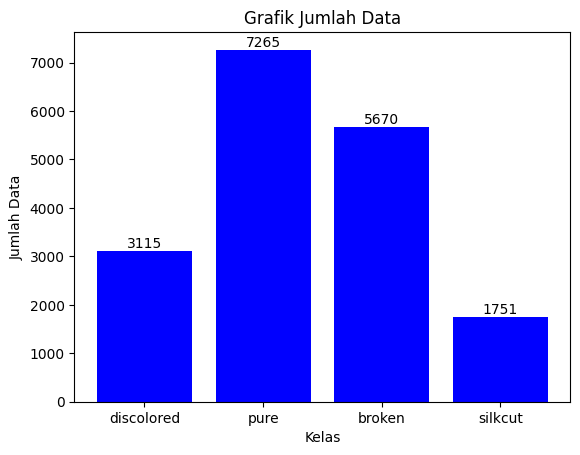

In [ ]:
n_data = [*get_n_data_class(dataset_segmentasi)]
classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

#### *4. Melatih Encoder-Decoder

In [ ]:
encoder = Encoder()
decoder = Decoder()
deepsmote = DeepSMOTE(encoder, decoder)

In [ ]:
deepsmote.fit(data_oversample, 'cuda')

Epoch :1 Train Loss: 34.90486764786195 Rec Loss: 17.368733443775955 Penalty_loss: 17.53613427524664
Menyimpan Model ....
Epoch :2 Train Loss: 13.678130614514254 Rec Loss: 6.723597525181819 Penalty_loss: 6.954533124760705
Menyimpan Model ....
Epoch :3 Train Loss: 7.419474243813632 Rec Loss: 3.5735912974543718 Penalty_loss: 3.8458829615645262
Menyimpan Model ....
Epoch :4 Train Loss: 5.171881788543293 Rec Loss: 2.4883160326553853 Penalty_loss: 2.683565749577722
Menyimpan Model ....
Epoch :5 Train Loss: 4.147928632339653 Rec Loss: 2.031458589115313 Penalty_loss: 2.1164700546282895
Menyimpan Model ....
Epoch :6 Train Loss: 3.609836716737066 Rec Loss: 1.7893866760542199 Penalty_loss: 1.820450041291057
Menyimpan Model ....
Epoch :7 Train Loss: 3.2951816236790346 Rec Loss: 1.6237471937677082 Penalty_loss: 1.6714344052027683
Menyimpan Model ....
Epoch :8 Train Loss: 2.9653961640231463 Rec Loss: 1.475708944228839 Penalty_loss: 1.4896872305520334
Menyimpan Model ....
Epoch :9 Train Loss: 2.79100

#### Timer

In [ ]:
f'waktu yg di tempuh: {deepsmote.timer:.2f} menit'

'waktu yg di tempuh: 40.11 menit'

#### Evaluasi

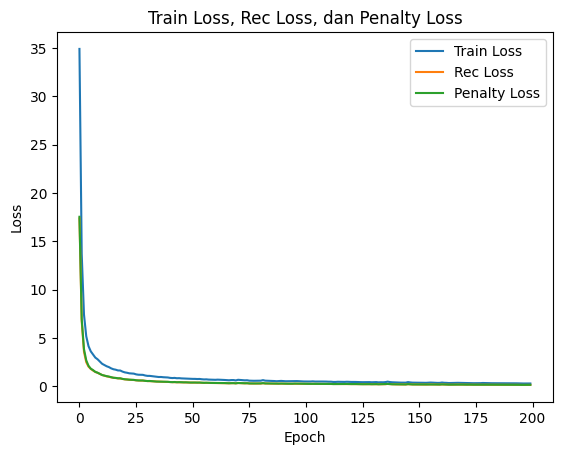

In [ ]:
# write_cachedImg(args['oversample']+"_perform.pkl")
performa=deepsmote.perform
plt.plot(performa['train_loss'], label='Train Loss')
plt.plot(performa['rec_loss'], label='Rec Loss')
plt.plot(performa['penalty_loss'], label='Penalty Loss')

# Menambahkan label dan judul plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss, Rec Loss, dan Penalty Loss')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

#### *5. Generate Data

In [ ]:
deepsmote.preprocess(data_oversample)
deepsmote.generate_samples(1500, args['target_oversample'], 'cpu')

berhasil menyimpan pkl drive/MyDrive/dataset/hasil_oversampling/combine_oversampling.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/hasil_oversampling/combine_oversampling_with_data.pkl
4.3992374142011


#### *6. Cek Ukuran Data

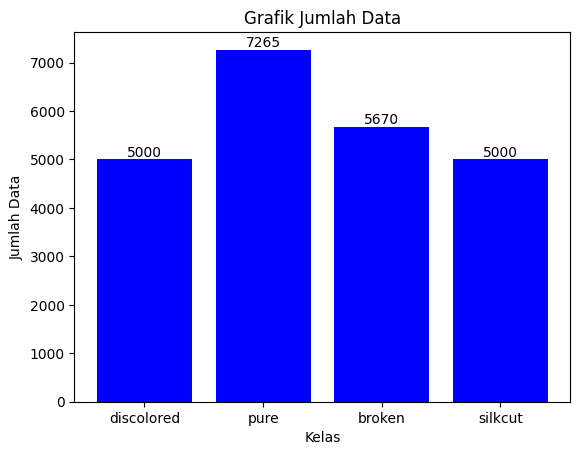

In [ ]:

n_data = [
    data_after_oversample['class'][data_after_oversample['class']==0].size(0),
    data_non_oversample['class'][data_non_oversample['class']==1].size(0),
    data_non_oversample['class'][data_non_oversample['class']==2].size(0),
    data_after_oversample['class'][data_after_oversample['class']==3].size(0)
]

classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

#### Menampilkan Ukuran Data

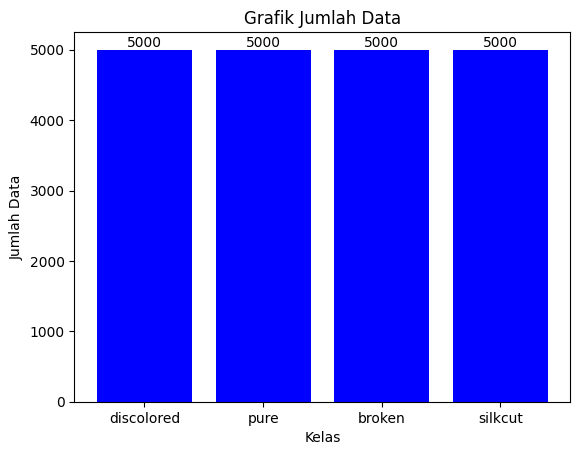

In [ ]:

n_data = [
    data_after_oversample['class'][data_after_oversample['class']==0].size(0),
    data_non_to_Balance['class'][data_non_to_Balance['class']==1].size(0),
    data_non_to_Balance['class'][data_non_to_Balance['class']==2].size(0),
    data_after_oversample['class'][data_after_oversample['class']==3].size(0)
]

classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

### d. Melakukan Classification

#### *1. Pembagian Data

#### a. Membagi Data Training dan Testing

In [ ]:
data_x, data_y = data_ready['images'], data_ready['class']
X_train, X_test, y_train, y_test = splitting_data(data_x, data_y, 0.2)

#### *2. Melihat Persebaran Data

#### *3.Pembagian KFOLD

In [ ]:
data_train = write_cachedImg(args['training'])
kfold_splitting(data_train['images'],data_train['class'], 5)

### Skenario 1

#### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 224, 224, 3])
Validation size torch.Size([3200, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 435MB/s]


Loaded pretrained weights for efficientnet-b0
fold ke-0
Epoch : 1 train loss : 0.8552759443223477 train acc : 0.6415625 val loss : 0.8109029993414879 val acc : 0.6828125 
Menyimpan Model
Epoch : 2 train loss : 0.608277615532279 train acc : 0.753359375 val loss : 0.6177288608253002 val acc : 0.763125 
Menyimpan Model
Epoch : 3 train loss : 0.4946631063520908 train acc : 0.805625 val loss : 0.6435261507332325 val acc : 0.763125 
Menyimpan Model
Epoch : 4 train loss : 0.40465494472533464 train acc : 0.842890625 val loss : 0.7318280959129333 val acc : 0.7596875 
Menyimpan Model
Epoch : 5 train loss : 0.33501575456932187 train acc : 0.87453125 val loss : 0.8096207278221845 val acc : 0.7690625 
Menyimpan Model
Epoch : 6 train loss : 0.2745907082594931 train acc : 0.898671875 val loss : 1.051563150882721 val acc : 0.749375 
Menyimpan Model
Epoch : 7 train loss : 0.22334741584490986 train acc : 0.917890625 val loss : 0.9881277504563332 val acc : 0.76375 
Menyimpan Model
Epoch : 8 train loss : 

#### Testing

In [ ]:
data_test = write_cachedImg(args['testing'])
x_test, y_test = Resize(data_test['images'], (260,260)), data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([4000, 260, 260, 3])


Hasil Testing


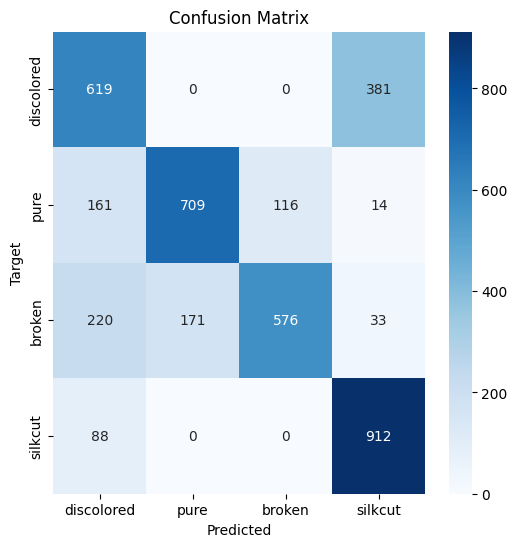

Loss : 5.398692862510681
Accuracy : 0.704
Precision : 0.7218956500291824
Recall : 0.7039999961853027
F1-score : 0.7018763422966003


In [ ]:
sistem.predict(x_test.to(torch.float32), y_test, 'cpu')